Author : Alex Aw   
Date : Oct 2022

## Sales forecasting with PyTorch LSTM on Time Series
<b>Objective :</b>   
Using LSTM to forecast 6 months of sales. It serve as an alternative to SARIMA/ARIMA forecasting which requires knowledge of the techniques. LSTM simply learns the sequence of the sales data and predict base on past trend. Unlike seqeunce of machinary time to failure which has higher predictability, sales is influenced by human behavior which can be erratic, thus the accuracy of prediction is less dependable. 

This model outcome was compared against SARIMA forecast. With some finetuning of the model bias, LSTM prediction was similar and mirrors the trend of SARIMA very closely. The results can still be a good reference guide for companies  to optmise their business operation in preparation for near future sales. Lastly, minimal tweaking of the model is necessary after the model is properly set up.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import MinMaxScaler

### Loading the data

In [2]:
df = pd.read_csv('supermart_bevsales_mthly.csv', parse_dates=['date'])
df.head()

,date,total_sale
0,2015-01-01,122497
1,2015-02-01,66030
2,2015-03-01,247156
3,2015-04-01,203258
4,2015-05-01,164263


### Plotting the data

In [3]:
#set date as index for plotting
df2 = df
df2['date'] = pd.to_datetime(df['date'])
df2.set_index('date', inplace=True)

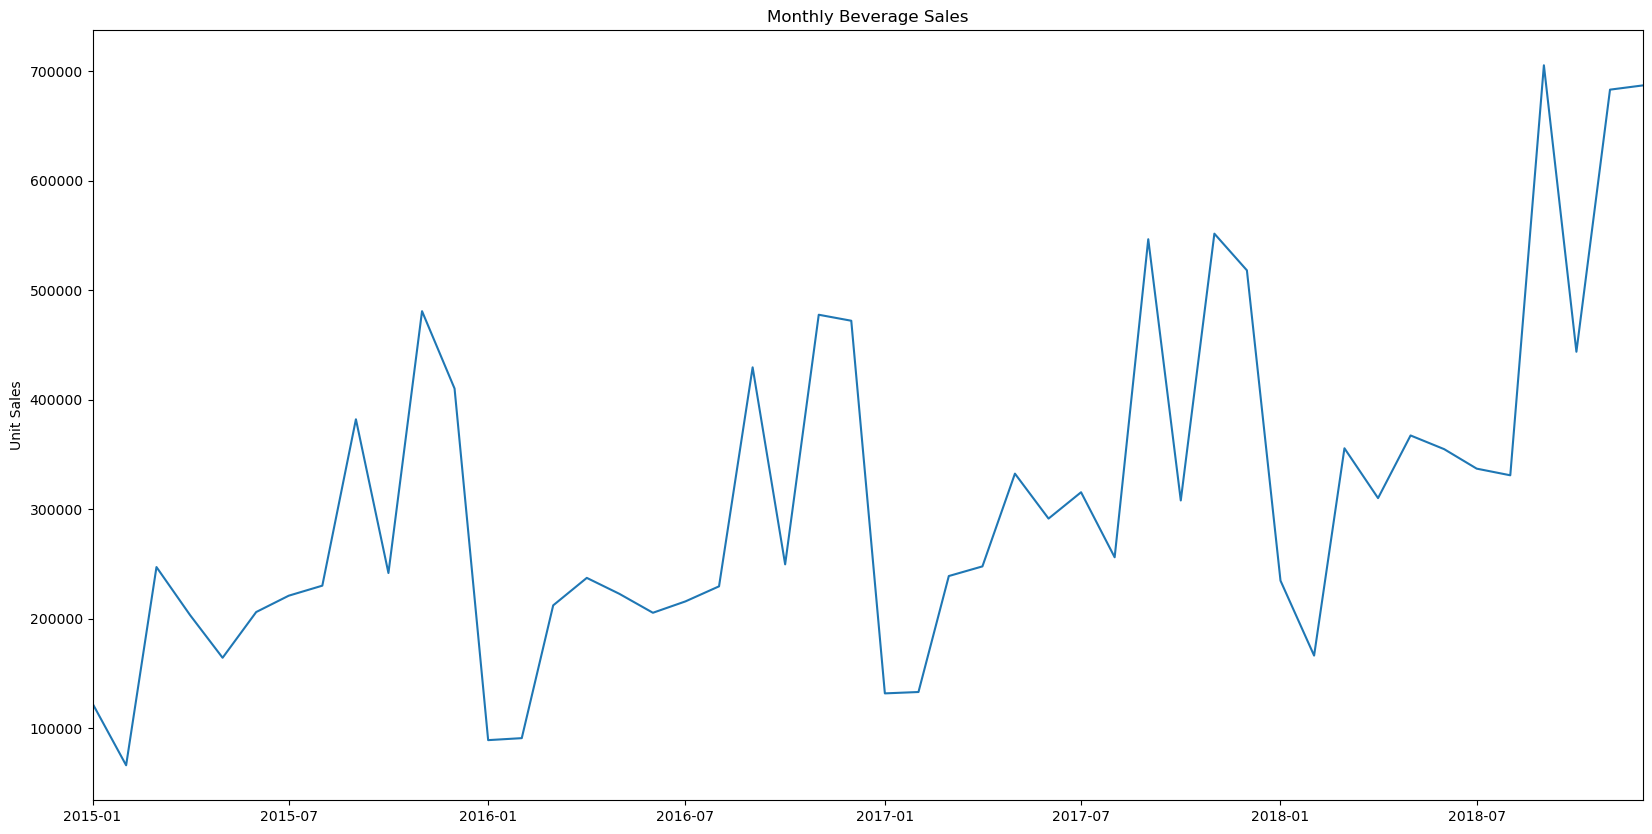

In [4]:
plt.figure(figsize=(20,10))
plt.title('Monthly Beverage Sales')
plt.ylabel('Unit Sales')
plt.autoscale(axis='x',tight=True)
plt.plot(df2['total_sale'])
plt.show()

### Data Prepping
<li> Normalise the training data between -1 and 1
<li> Defining the test size
<li> creating train test sets

In [5]:
# Extract values from the source .csv file
y = df['total_sale'].values.astype(float)

# Define a test size
test_size = 6

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

### Preparing data for LSTM
<li> Set window size.
<li> Training set = (len(train_data) - test_size) - window size)

In [7]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create sequence/label tuples
def input_data(seq,ws):  # ws is the window size
    output = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        output.append((window,label))
    return output

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)

30

In [8]:
# check first data sequence / label tuple
train_data[0]

(tensor([-0.7675, -1.0000, -0.2543, -0.4350, -0.5956, -0.4235, -0.3620, -0.3243,
          0.3017, -0.2767,  0.7084,  0.4173]),
 tensor([-0.9054]))

### Defining the model

In [9]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=1000,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [10]:
torch.manual_seed(42)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 1000)
  (linear): Linear(in_features=1000, out_features=1, bias=True)
)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  4000
4000000
  4000
  4000
  1000
     1
______
4013001


### Training the model

In [12]:
epochs = 50

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02886640
Epoch:  2 Loss: 0.04687720
Epoch:  3 Loss: 0.04745749
Epoch:  4 Loss: 0.04280071
Epoch:  5 Loss: 0.02125204
Epoch:  6 Loss: 0.02505064
Epoch:  7 Loss: 0.03149599
Epoch:  8 Loss: 0.03707981
Epoch:  9 Loss: 0.05655427
Epoch: 10 Loss: 0.02566379
Epoch: 11 Loss: 0.05169665
Epoch: 12 Loss: 0.01493345
Epoch: 13 Loss: 0.03739271
Epoch: 14 Loss: 0.05716366
Epoch: 15 Loss: 0.02601666
Epoch: 16 Loss: 0.17468880
Epoch: 17 Loss: 0.11608551
Epoch: 18 Loss: 0.08171250
Epoch: 19 Loss: 0.02736415
Epoch: 20 Loss: 0.00693989
Epoch: 21 Loss: 0.00829872
Epoch: 22 Loss: 0.03420461
Epoch: 23 Loss: 0.05174319
Epoch: 24 Loss: 0.05328175
Epoch: 25 Loss: 0.05364742
Epoch: 26 Loss: 0.05391442
Epoch: 27 Loss: 0.05378724
Epoch: 28 Loss: 0.05331573
Epoch: 29 Loss: 0.05246884
Epoch: 30 Loss: 0.05108985
Epoch: 31 Loss: 0.04881710
Epoch: 32 Loss: 0.04477210
Epoch: 33 Loss: 0.03668414
Epoch: 34 Loss: 0.02131009
Epoch: 35 Loss: 0.00598573
Epoch: 36 Loss: 0.04315581
Epoch: 37 Loss: 0.01064864
E

### Comparing predictions with known test data

In [13]:
future = 6

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [14]:
preds[window_size:]

[0.18553920090198517,
 -0.05963947996497154,
 0.9318559765815735,
 0.042118724435567856,
 0.9713203310966492,
 0.9527725577354431]

In [15]:
# Invert the normalisation
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[353988.58035509],
       [294436.51761261],
       [535263.32779184],
       [319152.82227497],
       [544848.92352089],
       [540343.80847976]])

### Plotting

In [16]:
x = np.arange('2018-07-01', '2019-01-01', dtype='datetime64[M]').astype('datetime64[D]')

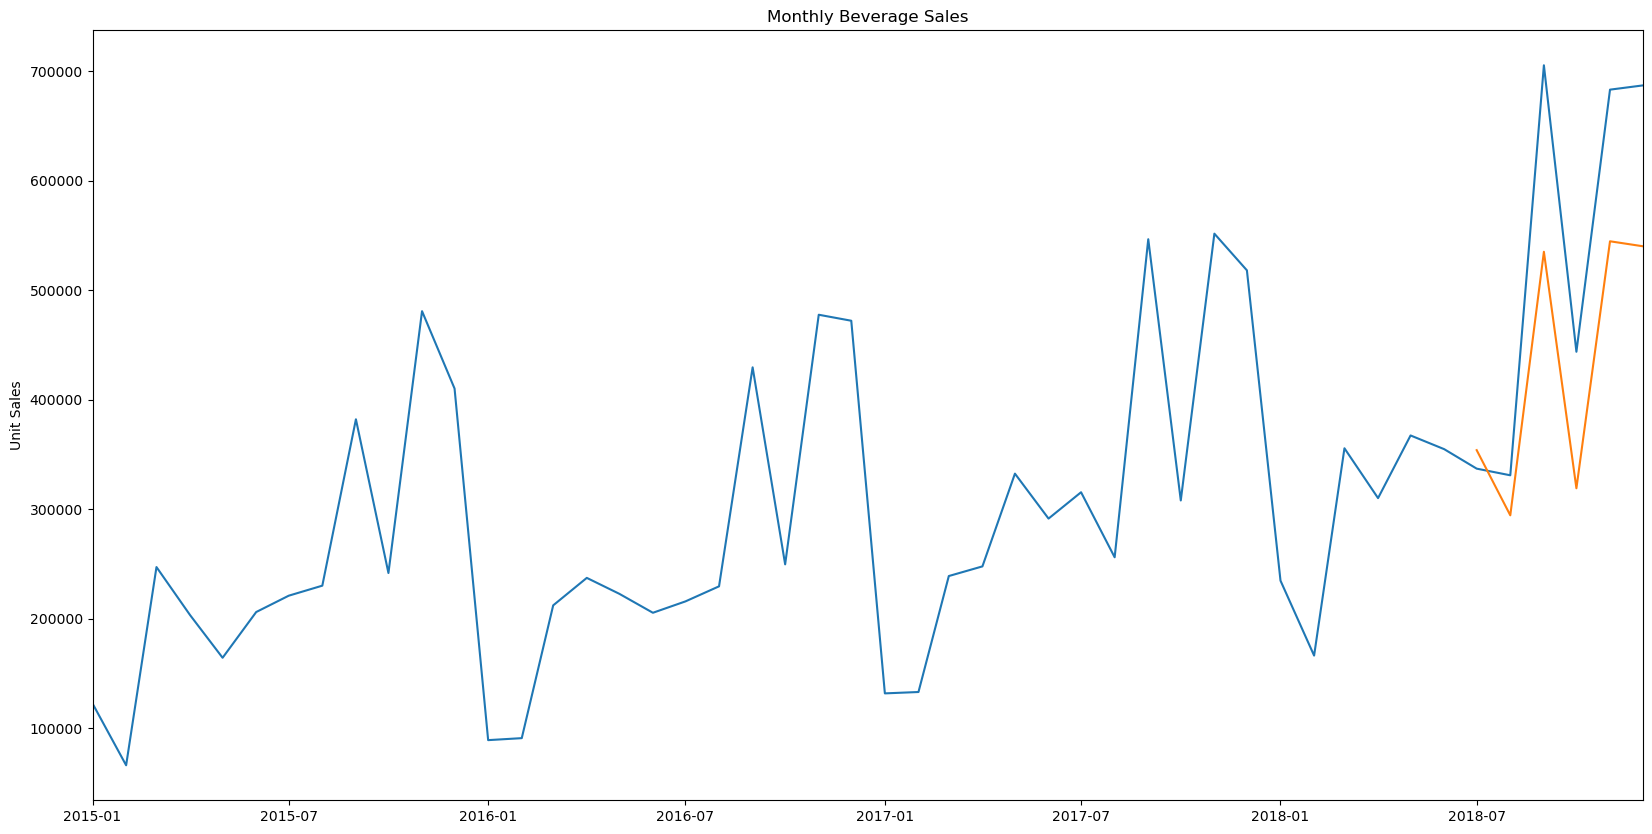

In [17]:
plt.figure(figsize=(20,10))
plt.title('Monthly Beverage Sales')
plt.ylabel('Unit Sales')
plt.autoscale(axis='x',tight=True)
plt.plot(df2['total_sale'])
plt.plot(x,true_predictions)
plt.show()

## Forecast into 2019

In [18]:
epochs = 50

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01226031
Epoch:  2 Loss: 0.01001448
Epoch:  3 Loss: 0.01529975
Epoch:  4 Loss: 0.02208828
Epoch:  5 Loss: 0.02382778
Epoch:  6 Loss: 0.01761148
Epoch:  7 Loss: 0.01882057
Epoch:  8 Loss: 0.01193282
Epoch:  9 Loss: 0.01246281
Epoch: 10 Loss: 0.00663991
Epoch: 11 Loss: 0.01006440
Epoch: 12 Loss: 0.00500870
Epoch: 13 Loss: 0.00930096
Epoch: 14 Loss: 0.00735105
Epoch: 15 Loss: 0.00484255
Epoch: 16 Loss: 0.00212169
Epoch: 17 Loss: 0.00147128
Epoch: 18 Loss: 0.00005019
Epoch: 19 Loss: 0.00000138
Epoch: 20 Loss: 0.00009080
Epoch: 21 Loss: 0.00017605
Epoch: 22 Loss: 0.00012930
Epoch: 23 Loss: 0.00046713
Epoch: 24 Loss: 0.00018315
Epoch: 25 Loss: 0.00472265
Epoch: 26 Loss: 0.00094614
Epoch: 27 Loss: 0.00006216
Epoch: 28 Loss: 0.00068951
Epoch: 29 Loss: 0.01801150
Epoch: 30 Loss: 0.00127060
Epoch: 31 Loss: 0.00497805
Epoch: 32 Loss: 0.00090881
Epoch: 33 Loss: 0.00284334
Epoch: 34 Loss: 0.00025081
Epoch: 35 Loss: 0.00066666
Epoch: 36 Loss: 0.00013599
Epoch: 37 Loss: 0.00015858
E

### Predict the future sales

In [19]:
window_size = 12
future = 6
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [20]:
# Invert the normalisation
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[273555.83624721],
       [164220.3104201 ],
       [399794.75449875],
       [370169.99894001],
       [407051.95965238],
       [421039.78641137]])

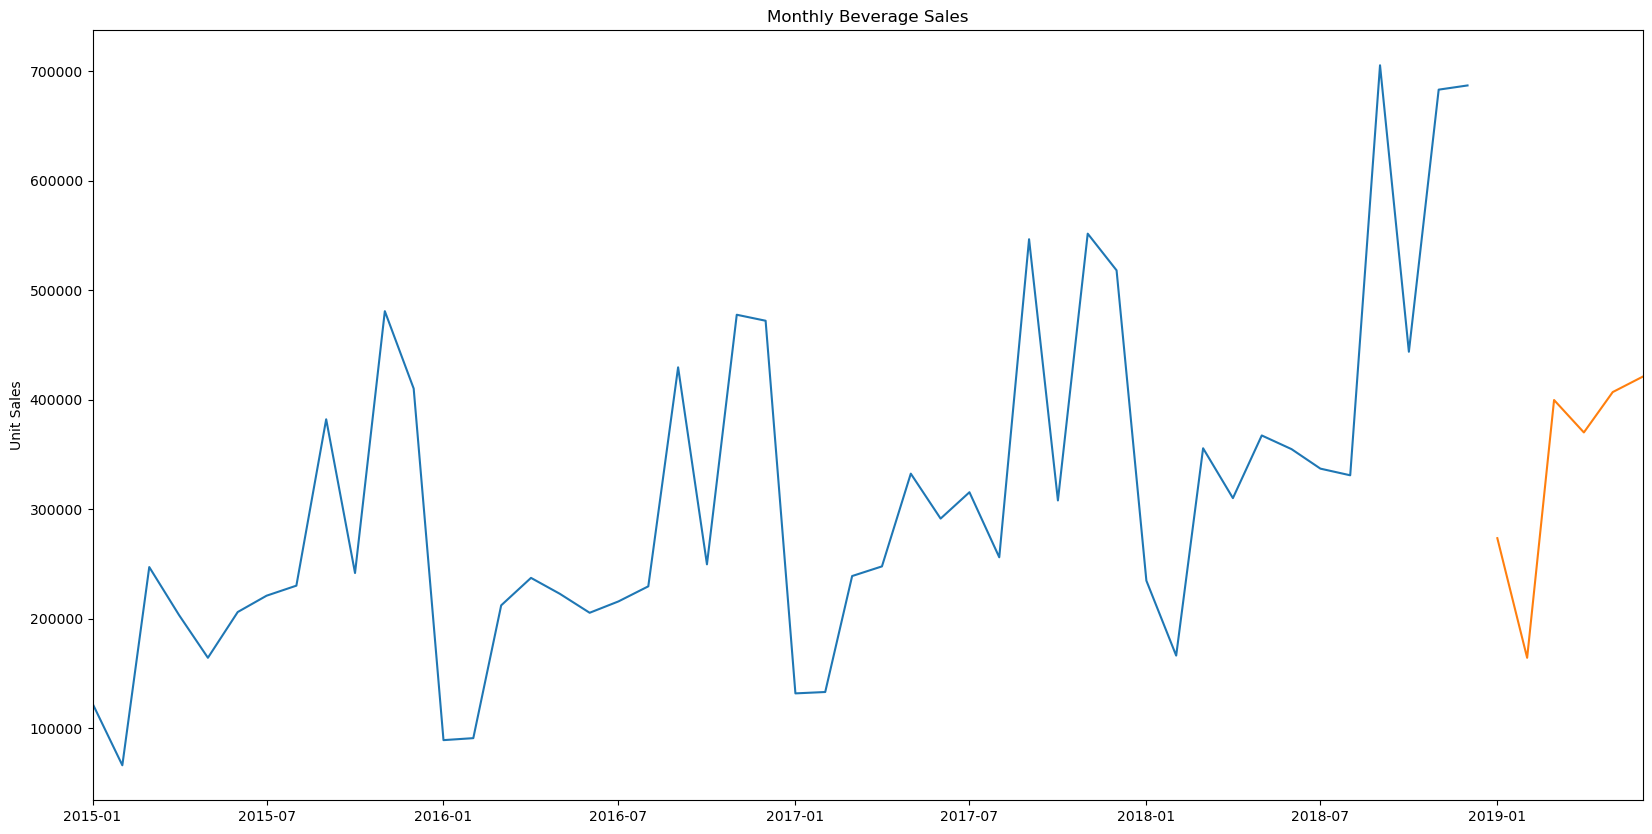

In [21]:
x = np.arange('2019-01-01', '2019-07-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(20,10))
plt.title('Monthly Beverage Sales')
plt.ylabel('Unit Sales')
plt.autoscale(axis='x',tight=True)
plt.plot(df2['total_sale'])
plt.plot(x,true_predictions)
plt.show()

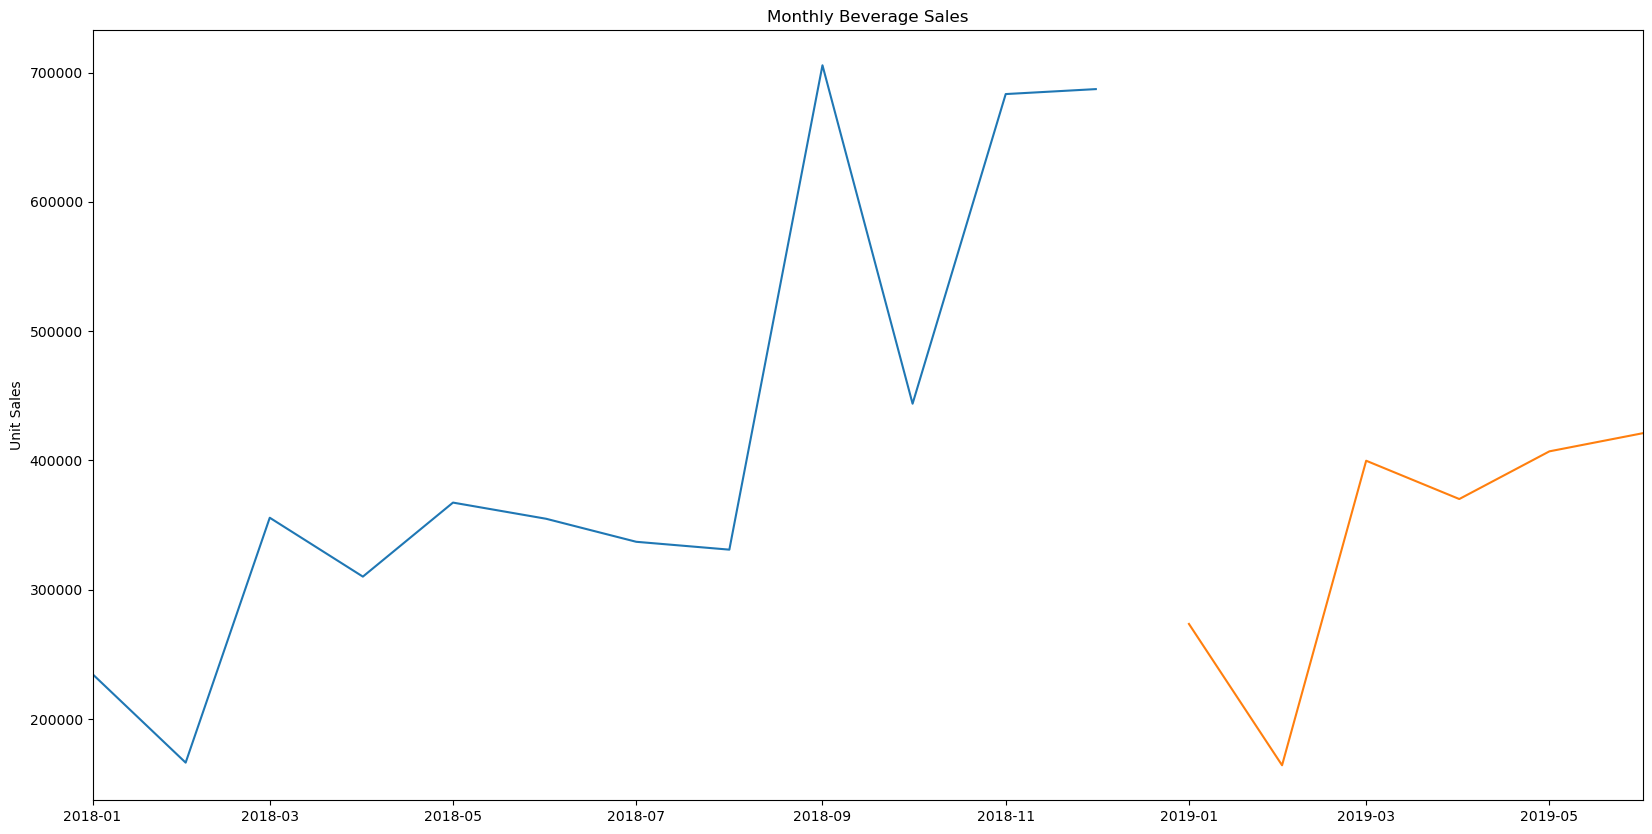

In [22]:
plt.figure(figsize=(20,10))
plt.title('Monthly Beverage Sales')
plt.ylabel('Unit Sales')
plt.autoscale(axis='x',tight=True)
plt.plot(df2['total_sale']['2018-01-01':])
plt.plot(x,true_predictions)
plt.show()

<HR>

## Comparing LSTM vs SARIMA

Prediction of sales against validation data of Jul - Dec 2018, the sales were mostly off by 20%. Hence the the forecasted sales was shifted by 20% and resulted in a new prediction that is very close to the original sales.

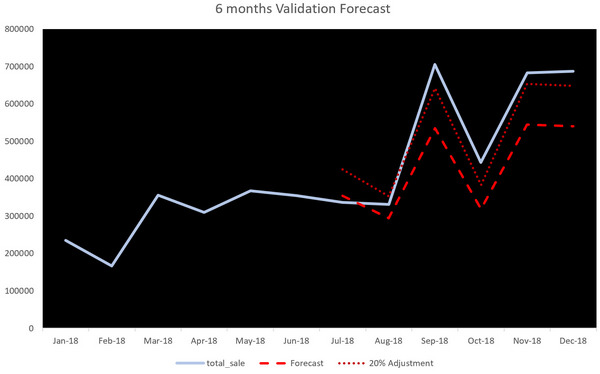

The following image shows both SARIMA and LSTM forecasting 6 months into 2019. Similar to validation data, 20% adjustment was added to LSTM's forecast. It is observed that LSTM mirrors the forecasting trend of SARIMA. On another exercise if the adjustment was 10%, LSTM will lie in between the UCL and LCL of SARIMA. 

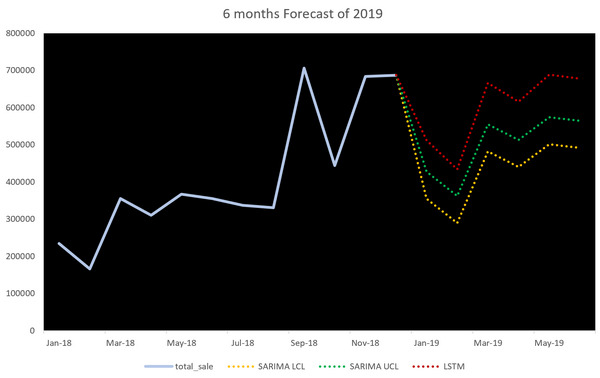

In closing remark, I'd say that LSTM can be used in place of SARIMA/ARIMA for predicting sales. 

End